In [1]:
pip install larq

/bin/bash: /home/ugrad/fyp/2022/e0726941/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Defaulting to user installation because normal site-packages is not writeable
--- Logging error ---
Traceback (most recent call last):
  File "/home/ugrad/fyp/2022/e0726941/.local/lib/python3.10/site-packages/pip/_internal/utils/logging.py", line 177, in emit
    self.console.print(renderable, overflow="ignore", crop=False, style=style)
  File "/home/ugrad/fyp/2022/e0726941/.local/lib/python3.10/site-packages/pip/_vendor/rich/console.py", line 1673, in print
    extend(render(renderable, render_options))
  File "/home/ugrad/fyp/2022/e0726941/.local/lib/python3.10/site-packages/pip/_vendor/rich/console.py", line 1305, in render
    for render_output in iter_render:
  File "/home/ugrad/fyp/2022/e0726941/.local/lib/python3.10/site-packages/pip/_internal/utils/logging.py", line 134, in __rich_console__
    for line in lines:
  File "/home/ugrad/fyp/2022/e0726941/.

In [2]:
import numpy as np
import tensorflow as tf
import larq as lq
import matplotlib.pyplot as plt

2022-10-25 09:26:27.876078: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-25 09:26:33.295485: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-25 09:26:52.686759: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/ugrad/fyp/2022/e0726941/miniconda3/lib/:/home/ugrad/fyp/2022/e0726941/miniconda3/lib/
2022-10-25 09:26:52.689674: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic libr

In [3]:
import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Download and prepare the MNIST dataset

In [49]:
(train_images_raw, train_labels_raw), (test_images_raw, test_labels_raw) = tf.keras.datasets.mnist.load_data()

train_images = train_images_raw.reshape((60000, 28, 28, 1))[:1000]
train_labels = train_labels_raw[:2000]
print(len(train_images), len(train_labels))

test_images = test_images_raw.reshape((10000, 28, 28, 1))[:100]
test_labels = test_labels_raw[:100]
print(len(test_images), len(test_labels))

eval_images = train_images_raw.reshape((60000, 28, 28, 1))[576:823]
eval_labels = train_labels_raw[576:823]
print(len(eval_images), len(eval_labels))

# Normalize pixel values to be between -1 and 1
train_images, test_images = train_images / 127.5 - 1, test_images / 127.5 - 1
eval_images = eval_images / 127.5 - 1

1000 2000
100 100
247 247


### Create the model


In [108]:
from keras.backend import sigmoid
from keras.backend import relu

def _clipped_gradient(x, dy, clip_value):
    if clip_value is None:
        return dy
    zeros = tf.zeros_like(dy)
    mask = tf.math.less_equal(tf.math.abs(x), clip_value)
    return tf.where(mask, dy, zeros)

@tf.custom_gradient
def my_sigmoid(x, clip_value=1.0):
    def ste_grad(dy):
        return _clipped_gradient(x, dy, clip_value)
    return sigmoid(x), ste_grad
    #return relu(x), ste_grad

@tf.custom_gradient
def my_sign(x, clip_value=1.0):
    def ste_grad(dy): return _clipped_gradient(x, dy, clip_value)
    return lq.math.sign(x), ste_grad

@tf.custom_gradient
def my_negative_sign(x, clip_value=1.0):
    x = x * -1
    def ste_grad(dy): return _clipped_gradient(x, dy * -1, clip_value)
    return lq.math.sign(x), ste_grad

#tf.keras.utils.get_custom_objects().update({'my_ste_sigmoid': tf.keras.layers.Activation(my_activation)})



In [132]:
# All quantized layers except the first will use the same options


kwargs_first = dict(input_shape=(28, 28, 1),
                    kernel_quantizer="ste_sign",
                    kernel_constraint="weight_clip",
                    #activation=tf.keras.layers.Activation(my_sign, name='my_sign'),
                    activation=tf.keras.layers.Activation(my_negative_sign, name='my_negative_sign'),
                   )
kwargs_second = dict(#input_quantizer=tf.keras.layers.Activation(my_activation, name='my_sign'),
              kernel_quantizer="ste_sign",
              activation="leaky_relu",
              #activation=tf.keras.layers.Activation(my_activation, name='my_activation'),
              #activation="relu",
              #activation="sigmoid",
              kernel_constraint="weight_clip")

# kwargs_first = dict(input_shape=(28, 28, 1),
#                     kernel_quantizer="ste_sign",
#                     kernel_constraint="weight_clip")
# kwargs_second = dict(input_quantizer="ste_sign",
#               kernel_quantizer="ste_sign", 
#               activation="leaky_relu",
#               #activation=tf.keras.layers.Activation(my_activation, name='my_activation'),
#               #activation="relu",
#               #activation="sigmoid",
#               kernel_constraint="weight_clip")

# Working fully connected
# https://www.tensorflow.org/datasets/keras_example
# model1 = tf.keras.models.Sequential()
# model1.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
# model1.add(tf.keras.layers.Dense(128, activation='relu', use_bias=False))
# model1.add(tf.keras.layers.Dense(10, use_bias=False))
# model1.add(tf.keras.layers.Activation("softmax"))

model2 = tf.keras.models.Sequential()
model2.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
model2.add(lq.layers.QuantDense(128, use_bias=False, **kwargs_first))
model2.add(lq.layers.QuantDense(10, use_bias=False, **kwargs_second))

In [133]:
#lq.models.summary(model1)
lq.models.summary(model2)

+sequential_21 stats---------------------------------------------------+
| Layer           Input prec.    Outputs  # 1-bit  Memory  32-bit MACs |
|                       (bit)                 x 1    (kB)              |
+----------------------------------------------------------------------+
| flatten_21                -  (-1, 784)        0       0            0 |
| quant_dense_42            -  (-1, 128)   100352   12.25       100352 |
| quant_dense_43            -   (-1, 10)     1280    0.16         1280 |
+----------------------------------------------------------------------+
| Total                                    101632   12.41       101632 |
+----------------------------------------------------------------------+
+sequential_21 summary----------------------+
| Total params                   102 k      |
| Trainable params               102 k      |
| Non-trainable params           0          |
| Model size                     12.41 KiB  |
| Model size (8-bit FP weights)  12.41 K

### Compile and train the model


In [134]:
is_normalised_ouput = False
# model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=not is_normalised_ouput),
#               metrics=['accuracy']
#               )

model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.5e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=not is_normalised_ouput),
              metrics=['accuracy']
              )

# model.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
#     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#     metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
# )

In [135]:
# history1 = model1.fit(train_images, train_labels, validation_split=0.2, batch_size=2, epochs=10)

# test_loss, test_acc = model1.evaluate(test_images, test_labels)
# print(f"Test loss {test_loss * 100:.2f} %")
# print(f"Test accuracy {test_acc * 100:.2f} %")

In [136]:
history2 = model2.fit(train_images, train_labels, validation_split=0.2, batch_size=4, epochs=300)

test_loss, test_acc = model2.evaluate(test_images, test_labels)
print(f"Test loss {test_loss * 100:.2f} %")
print(f"Test accuracy {test_acc * 100:.2f} %")

Epoch 1/300
200/200 [==============================] - 1s 5ms/step - loss: 8.7046 - accuracy: 0.0725 - val_loss: 6.9513 - val_accuracy: 0.0950
Epoch 2/300
200/200 [==============================] - 1s 4ms/step - loss: 5.3276 - accuracy: 0.0925 - val_loss: 4.9293 - val_accuracy: 0.1050
Epoch 3/300
200/200 [==============================] - 1s 4ms/step - loss: 3.9613 - accuracy: 0.1138 - val_loss: 3.6812 - val_accuracy: 0.1150
Epoch 4/300
200/200 [==============================] - 1s 4ms/step - loss: 3.2219 - accuracy: 0.1425 - val_loss: 3.1168 - val_accuracy: 0.1250
Epoch 5/300
200/200 [==============================] - 1s 4ms/step - loss: 2.8416 - accuracy: 0.1513 - val_loss: 2.7551 - val_accuracy: 0.1400
Epoch 6/300
200/200 [==============================] - 1s 3ms/step - loss: 2.5614 - accuracy: 0.1937 - val_loss: 2.5373 - val_accuracy: 0.1550
Epoch 7/300
200/200 [==============================] - 1s 4ms/step - loss: 2.3903 - accuracy: 0.2338 - val_loss: 2.4733 - val_accuracy: 0.2000

### Evaluate the model

1/1 [==============================] - 0s 163ms/step


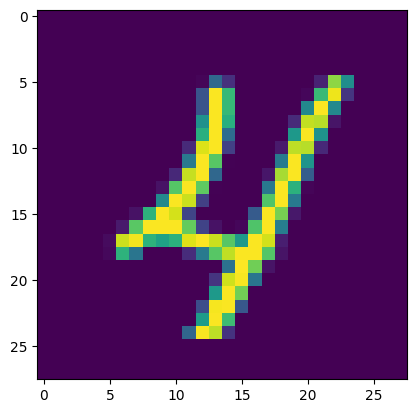

prediction shape: (1, 10)
prediction: [[-3.2       -2.4       -3.6000001 -5.2000003  8.        -4.4
  -2.8       -2.8       -2.        -3.2      ]]


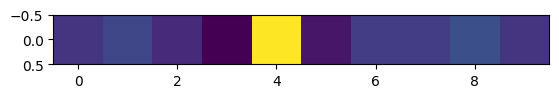

In [114]:
gg=103
input_data = eval_images[gg+1:gg+2]
prediction = model2.predict(input_data)
plt.imshow(input_data.reshape((28, 28)), interpolation='nearest')
plt.show()

print("prediction shape:", prediction.shape)
print("prediction:", prediction)
plt.imshow(prediction)#, interpolation='nearest')
plt.show()
#print(eval_images)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


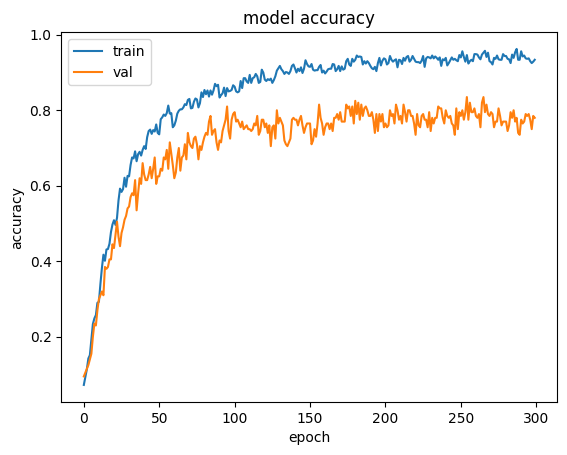

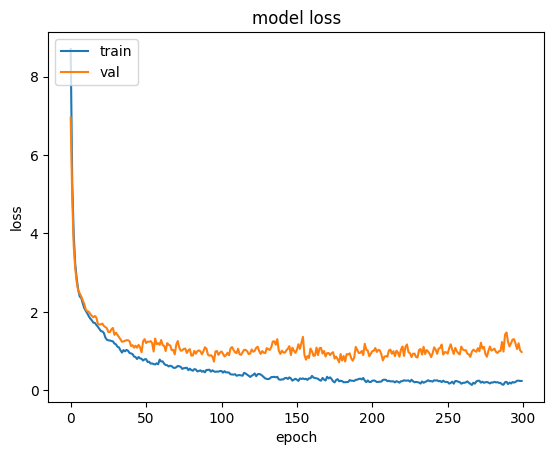

In [137]:
# print(history1.history.keys())
# # summarize history for accuracy
# plt.plot(history1.history['accuracy'])
# plt.plot(history1.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()
# # summarize history for loss
# plt.plot(history1.history['loss'])
# plt.plot(history1.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()


print(history2.history.keys())
# summarize history for accuracy
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [138]:
# Save to file
#np.save('week11_sign_leakyrelu.npy', history2.history)
np.save('week11_negative_sign_leakyrelu.npy', history2.history)

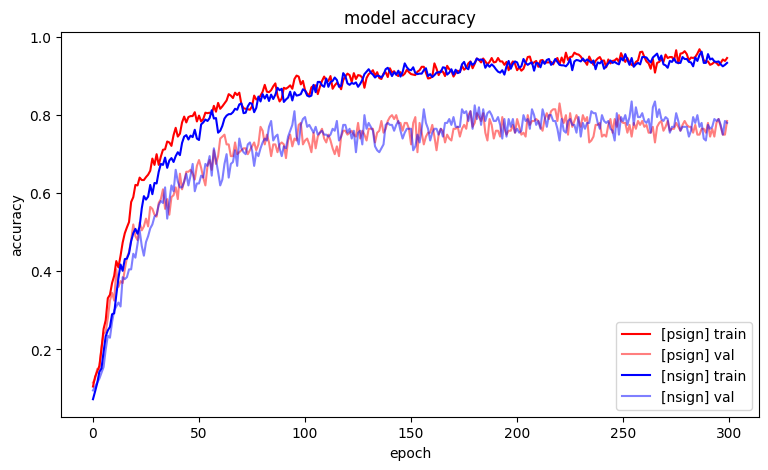

In [145]:
history_psign = np.load('week11_sign_leakyrelu.npy',allow_pickle='TRUE').item()
history_nsign = np.load('week11_negative_sign_leakyrelu.npy',allow_pickle='TRUE').item()

legend =  ['[psign] train', '[psign] val']
legend += ['[nsign] train', '[nsign] val']

# summarize history for accuracy
plt.figure(figsize=(9, 5))
plt.plot(history_psign['accuracy'], 'r-')
plt.plot(history_psign['val_accuracy'], 'r', alpha=0.5)
plt.plot(history_nsign['accuracy'], 'b')
plt.plot(history_nsign['val_accuracy'], 'b', alpha=0.5)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(legend, loc='lower right')
plt.show()

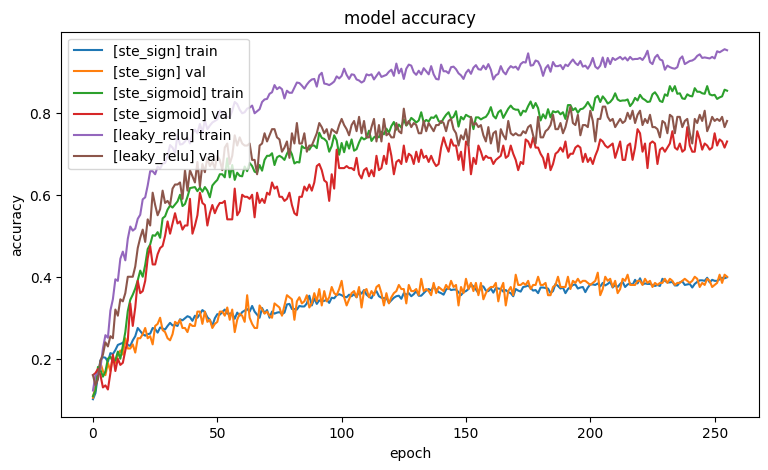

In [138]:
history_leaky_relu = np.load('history_256_leaky_relu.npy',allow_pickle='TRUE').item()
history_ste_sign = np.load('history_256_ste_sign.npy',allow_pickle='TRUE').item()
history_ste_sigmoid = np.load('history_256_ste_sigmoid.npy',allow_pickle='TRUE').item()
history_sigmoid = np.load('history_256_sigmoid.npy',allow_pickle='TRUE').item()

# summarize history for accuracy
plt.figure(figsize=(9, 5))
plt.plot(history_ste_sign['accuracy'])
plt.plot(history_ste_sign['val_accuracy'])
plt.plot(history_ste_sigmoid['accuracy'])
plt.plot(history_ste_sigmoid['val_accuracy'])
plt.plot(history_leaky_relu['accuracy'])
plt.plot(history_leaky_relu['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['[ste_sign] train', '[ste_sign] val', 
            '[ste_sigmoid] train', '[ste_sigmoid] val',
            '[leaky_relu] train', '[leaky_relu] val'], loc='upper left')
plt.show()


### Layers

In [46]:
model2.layers

In [95]:
#model.save("full_precision_model.h5")  # save full precision latent weights
fp_weights = model2.get_weights()  # get latent weights

with lq.context.quantized_scope(True):
    #model.save("binary_model.h5")  # save binarized weights
    weights = model2.get_weights()  # get binarized weights

weights

[array([[ 1.,  1., -1., ...,  1.,  1.,  1.],
        [ 1.,  1., -1., ..., -1., -1., -1.],
        [ 1., -1., -1., ...,  1., -1., -1.],
        ...,
        [ 1.,  1., -1., ...,  1.,  1., -1.],
        [-1., -1.,  1., ...,  1., -1.,  1.],
        [-1.,  1., -1., ..., -1.,  1., -1.]], dtype=float32),
 array([[-1.,  1.,  1., ..., -1., -1., -1.],
        [-1., -1., -1., ...,  1., -1.,  1.],
        [ 1., -1.,  1., ..., -1.,  1.,  1.],
        ...,
        [ 1., -1.,  1., ..., -1., -1.,  1.],
        [ 1., -1., -1., ..., -1., -1., -1.],
        [ 1., -1., -1., ..., -1.,  1.,  1.]], dtype=float32)]

In [139]:
from IPython.display import HTML
HTML(pd.DataFrame(weights[1].T).to_html())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127
0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,1.0
1,1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0
2,1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0
3,1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,1.0
4,-1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
5,1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,1.0,-1.0,-1.0
6,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,1.0,-